In [70]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
from fates_calibration.FATES_calibration_constants import FATES_PFT_IDS, FATES_INDEX
import fates_calibration.emulation_functions as emf
from fates_calibration.FATES_calibration_constants import OBS_MODEL_VARS, VAR_UNITS
from matplotlib.patches import Rectangle

In [71]:
def plot_parameter_hists(sample, param_list):
    
    pars = [par for par in sample.columns if par != 'wave']
    
    plt.figure(figsize=[18, 16])
    for i, par in enumerate(pars):
        p = get_default_value(par, param_list)
        ax = plt.subplot(7, 5, i + 1)
        ax.hist(sample[par])
        ax.axvline(x=p, color='r', linestyle='-')
        ax.set_xlabel(par)
        ax.set_xlim(0, 1)
    plt.tight_layout()

def get_param_samples(sample_dir):
    
    files = sorted([os.path.join(sample_dir, file) for file in os.listdir(sample_dir) if file.endswith(".csv")])
    sample_dfs = []
    for file in files:
        df = pd.read_csv(file, index_col=[0])
        sample_dfs.append(df)
    sample_df = pd.concat(sample_dfs)
    sample_df = sample_df.drop(columns=['wave'])

    return sample_df

def get_default_pars(lhckey, in_pars):
    
    lhkey_df = pd.read_csv(lhckey)
    lhkey_df = lhkey_df.drop(columns=['ensemble'])
    param_names = lhkey_df.columns

    default_pars = [par for par in param_names if par not in in_pars]

    return default_pars
    
def get_param_value(change_str, default_value, param_list_file,
                    parameter, type):
    
    if change_str == 'pft':
        pft_values = pd.read_excel(param_list_file,
                                   parameter.replace("fates_", ""))
        param_value = pft_values[type].values
    
    elif 'percent' in change_str:
        percent_change = get_percentage_change(change_str)
        if type == 'param_min':
            param_value = default_value - np.abs(default_value*(percent_change/100.0))
        else:
            param_value = default_value + np.abs(default_value*(percent_change/100.0))
    else:
        numeric_value = float(change_str)
        if default_value.size == 1:
            param_value = numeric_value
        else:
            param_value = np.full_like(default_value, numeric_value)

    if default_value.size == 1:
        if default_value == -999.9:
            param_value = -999.9
    else:
        param_value[default_value == -999.9] = -999.9

    return param_value
    
def get_percentage_change(param_change):
    return float(param_change.replace('percent', ''))

def unnormalize(value, min_value, max_value):
    return (max_value - min_value)*value + min_value
    
def normalize(value, min_value, max_value):
    return (value - min_value)/(max_value - min_value)

def get_default_value(parameter, param_list):

    sub = param_list[param_list.parameter == parameter]
    min_value = float(sub[sub.type == 'min'].val.values[0])
    max_value = float(sub[sub.type == 'max'].val.values[0])
    default_value = float(sub[sub.type == 'max'].default.values[0])
    
    rescaled_default = normalize(default_value, min_value, max_value)

    return rescaled_default

def get_rescaled_value(value, parameter, param_list):

    sub = param_list[param_list.parameter == parameter]
    min_value = float(sub[sub.type == 'min'].val.values[0])
    max_value = float(sub[sub.type == 'max'].val.values[0])
    
    rescaled_value = unnormalize(value, min_value, max_value)
    
    return rescaled_value

def choose_pars(sample_df, var_choose, param_list):
    
    var_median = sample_df[var_choose].median()
    sample_df['var_diff'] = np.abs(sample_df[var_choose] - var_median)
    choose_index = np.argmin(sample_df.var_diff)
    sample_df = sample_df.drop(columns=['var_diff'])
    
    final_pars_scaled = sample_df.iloc[choose_index]
    pars = sample_df.columns
    
    final_pars = []
    for i, parval in enumerate(final_pars_scaled):
        final_pars.append(get_rescaled_value(parval, pars[i], param_list))
    
    final_pars_df = pd.DataFrame({'parameter': pars, 'value': final_pars})
    return final_pars_df

In [118]:
def get_corr(sample_df):
    corr = sample_df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    (corr
     .style
     .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
     .highlight_null(color='#f1f1f1')
     .format(precision=2))

In [137]:
dom_pfts = ['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree',
            'needleleaf_colddecid_extratrop_tree', 'arctic_c3_grass', 'cool_c3_grass',
            'c4_grass']
codom_pfts = ['broadleaf_evergreen_extratrop_tree', 'broadleaf_hydrodecid_tropical_tree',
           'broadleaf_colddecid_extratrop_tree', 'broadleaf_colddecid_extratrop_shrub', 'c3_crop',
            'c3_irrigated']
all_pfts = ['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree',
            'needleleaf_colddecid_extratrop_tree', 'arctic_c3_grass', 'cool_c3_grass',
            'c4_grass', 'broadleaf_evergreen_extratrop_tree', 'broadleaf_hydrodecid_tropical_tree',
           'broadleaf_colddecid_extratrop_tree', 'broadleaf_colddecid_extratrop_shrub', 'c3_crop',
            'c3_irrigated']

In [141]:
#lhckey = '/glade/u/home/afoster/FATES_Calibration/lh_key_dompft.csv'
min_max_pars = pd.read_csv('/glade/u/home/afoster/FATES_Calibration/FATES_LH_min_max_crops.csv')

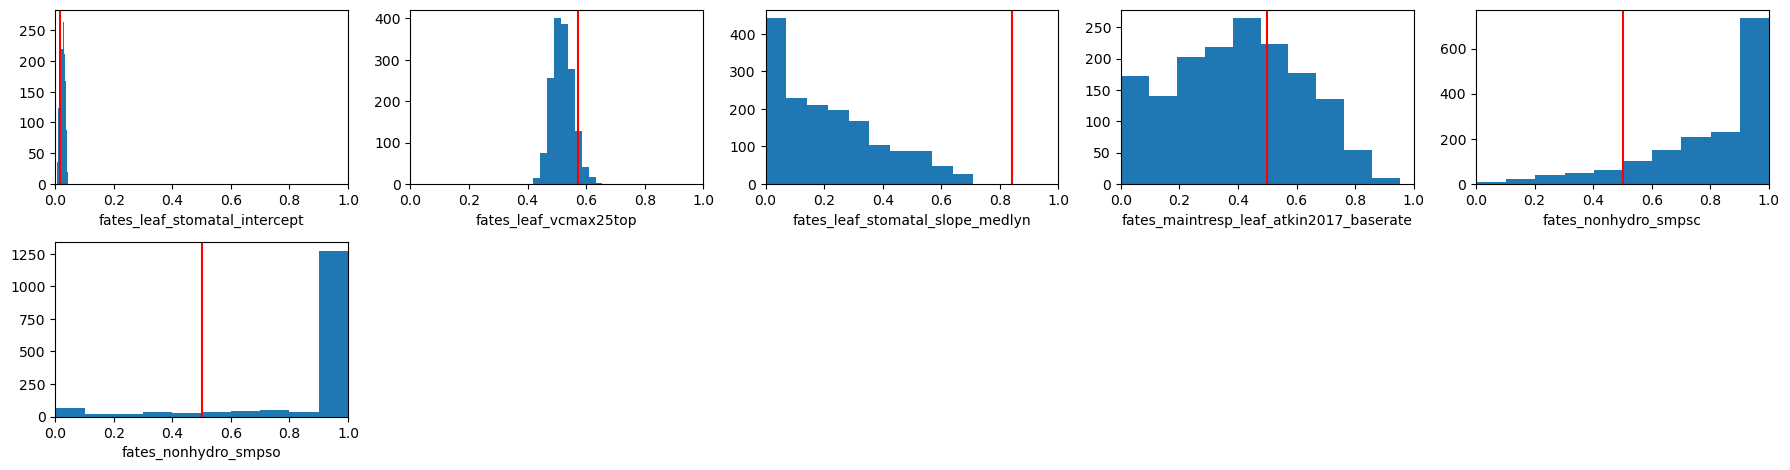

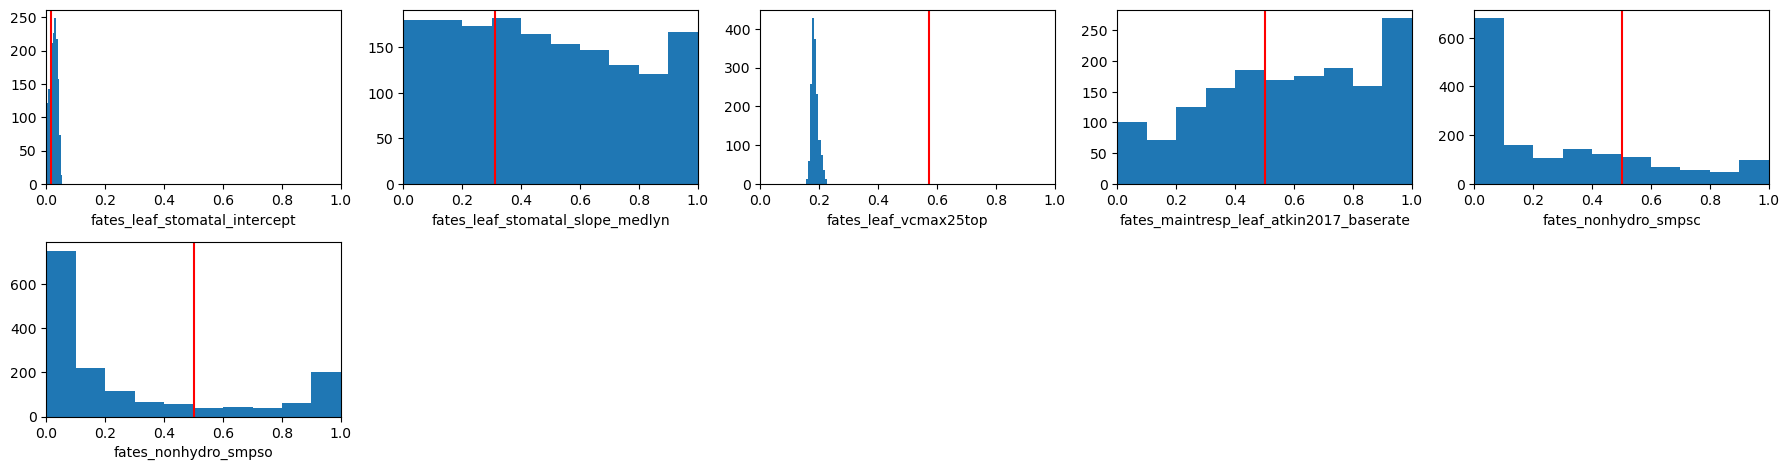

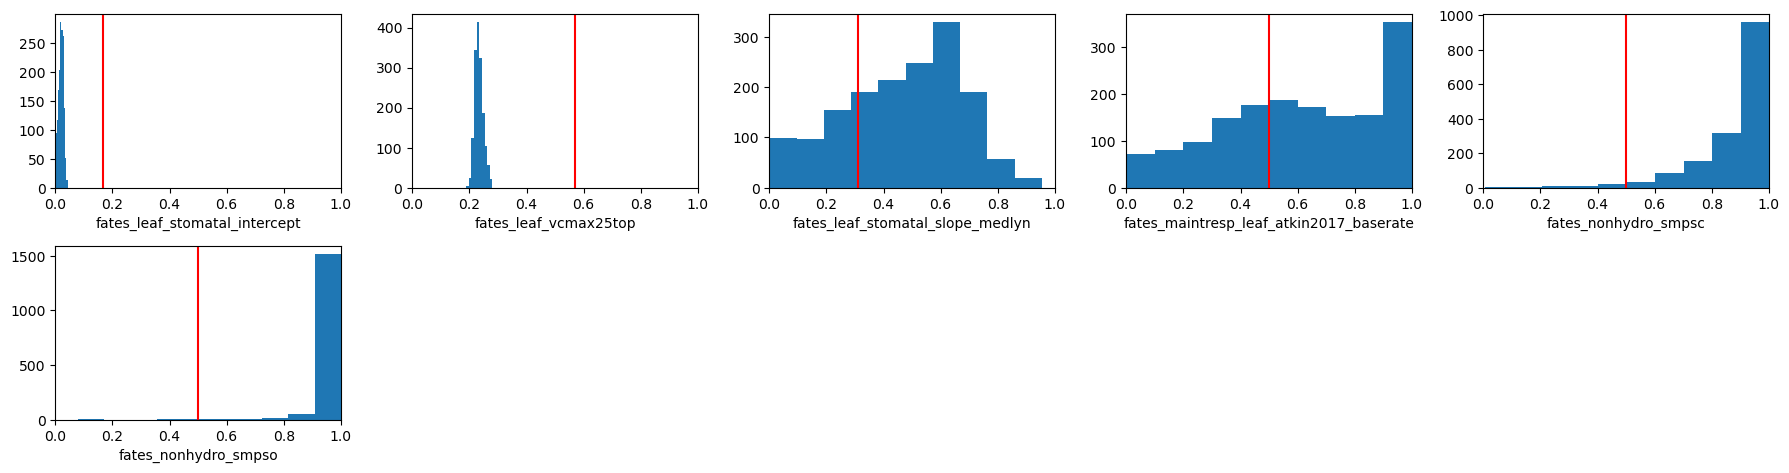

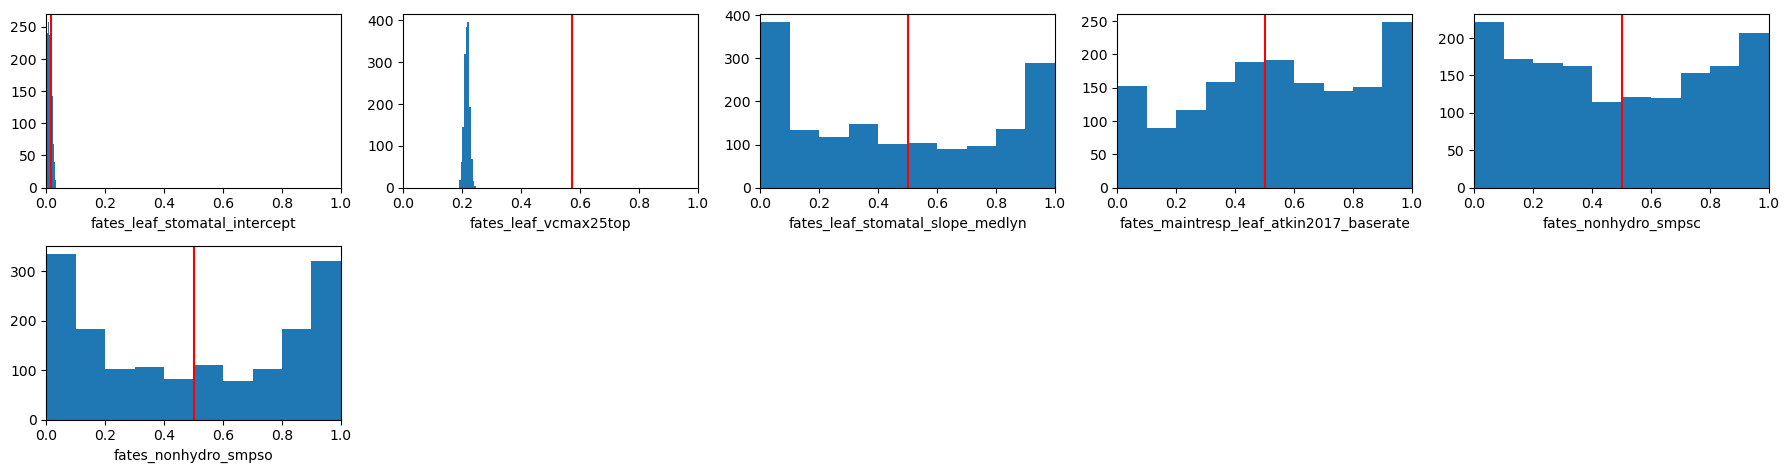

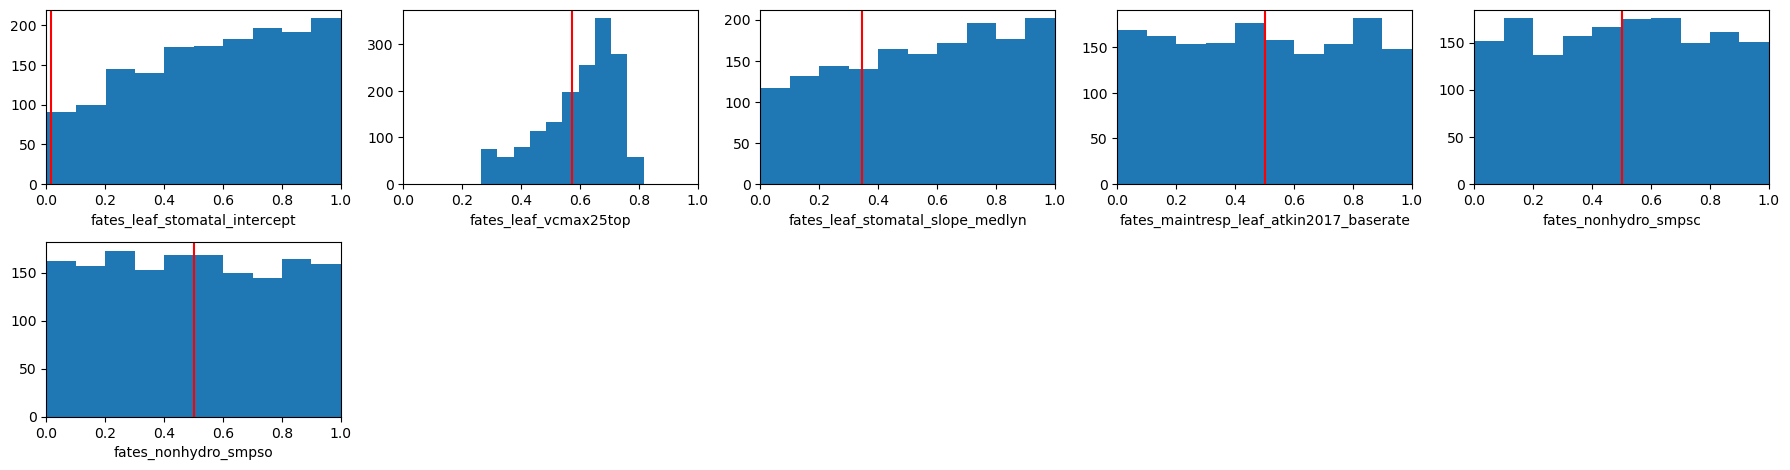

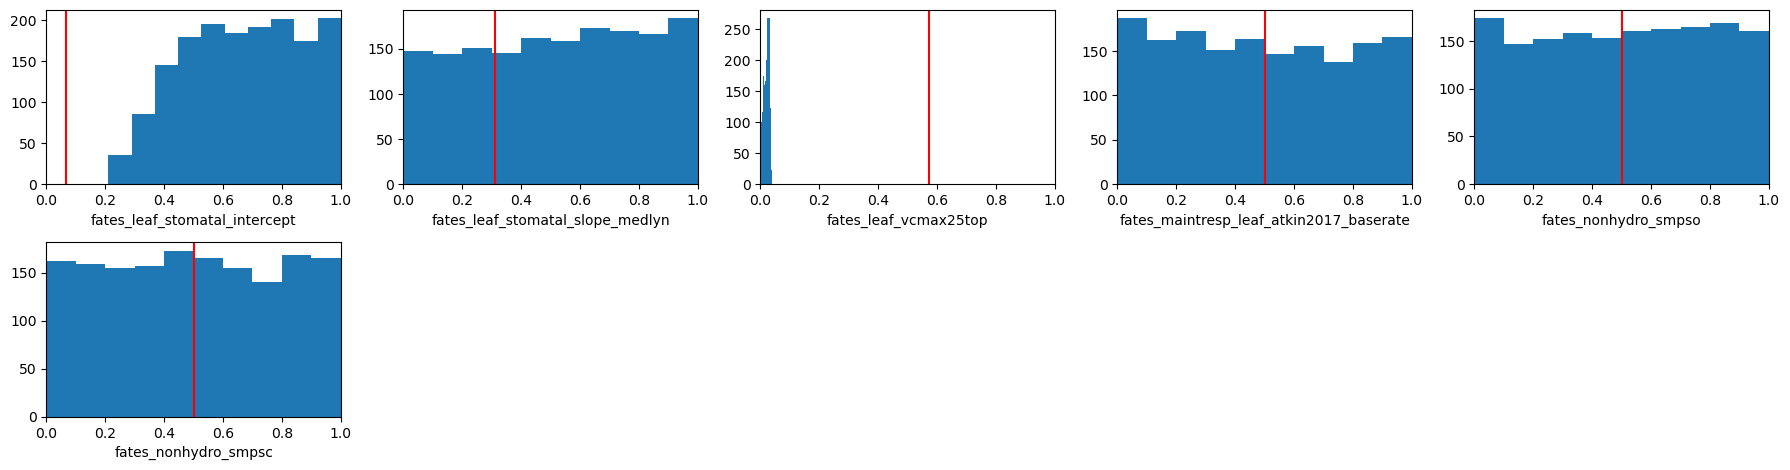

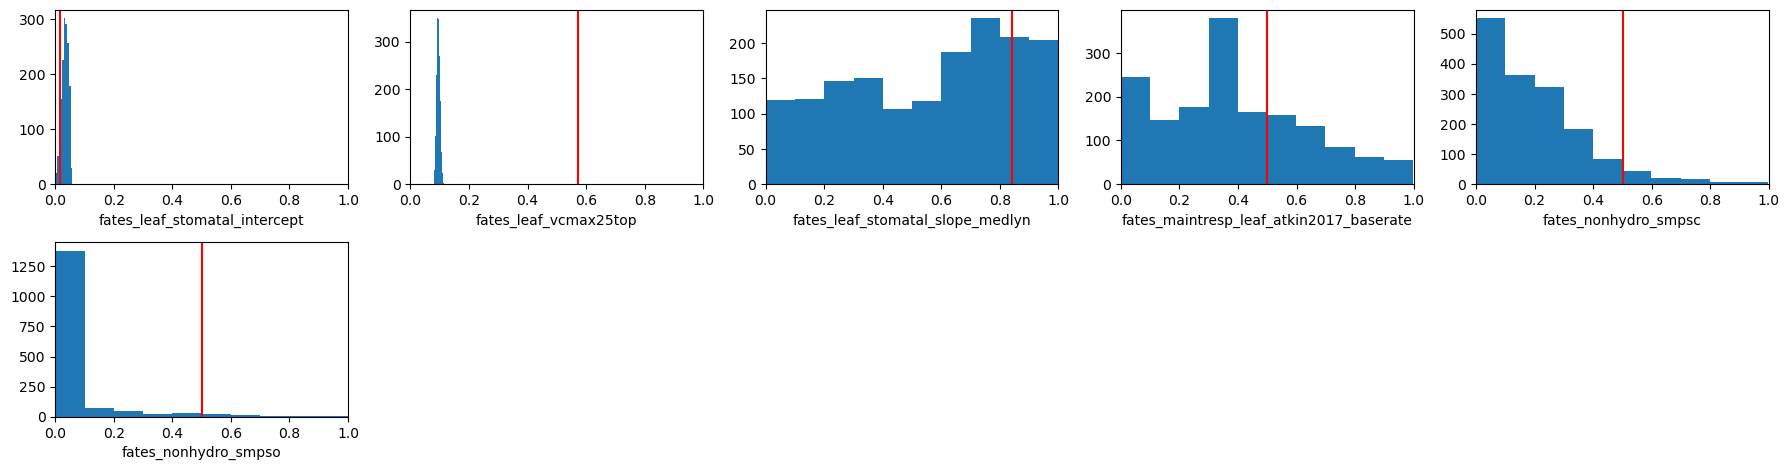

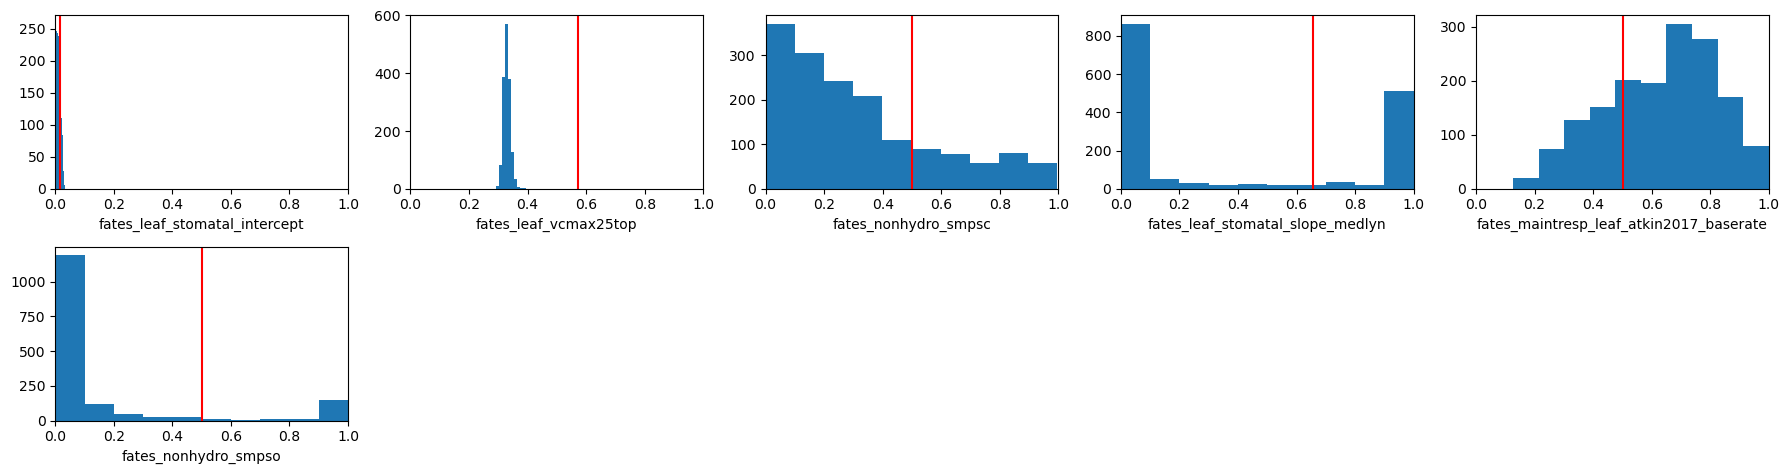

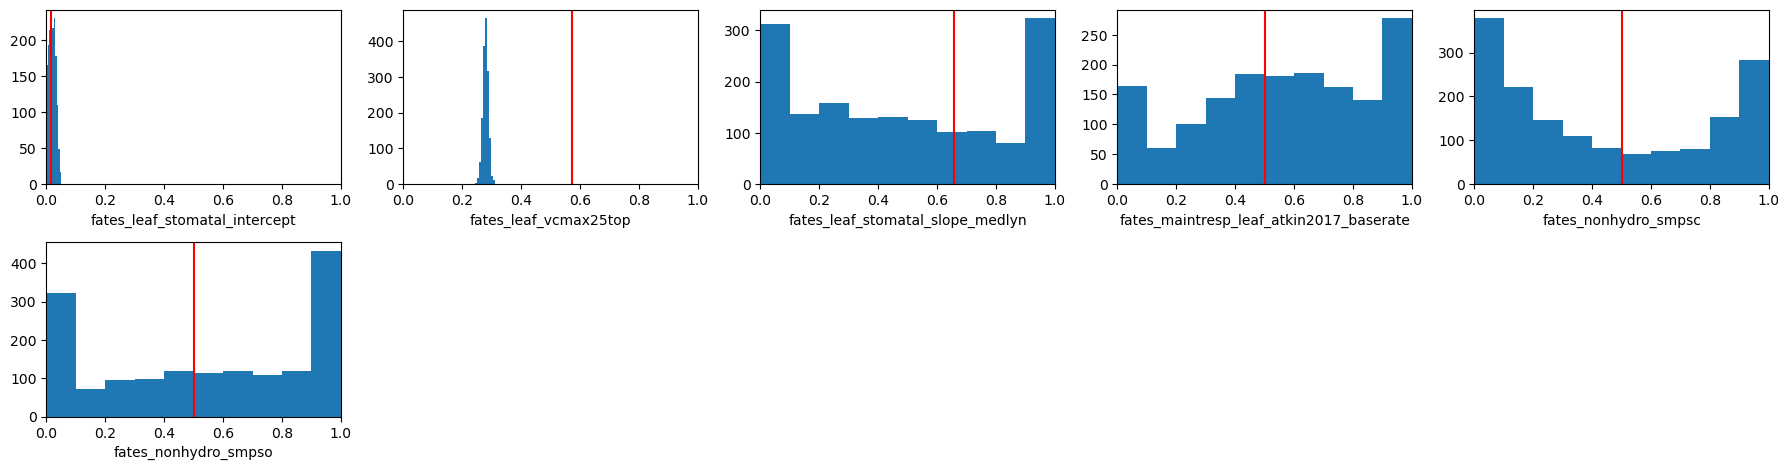

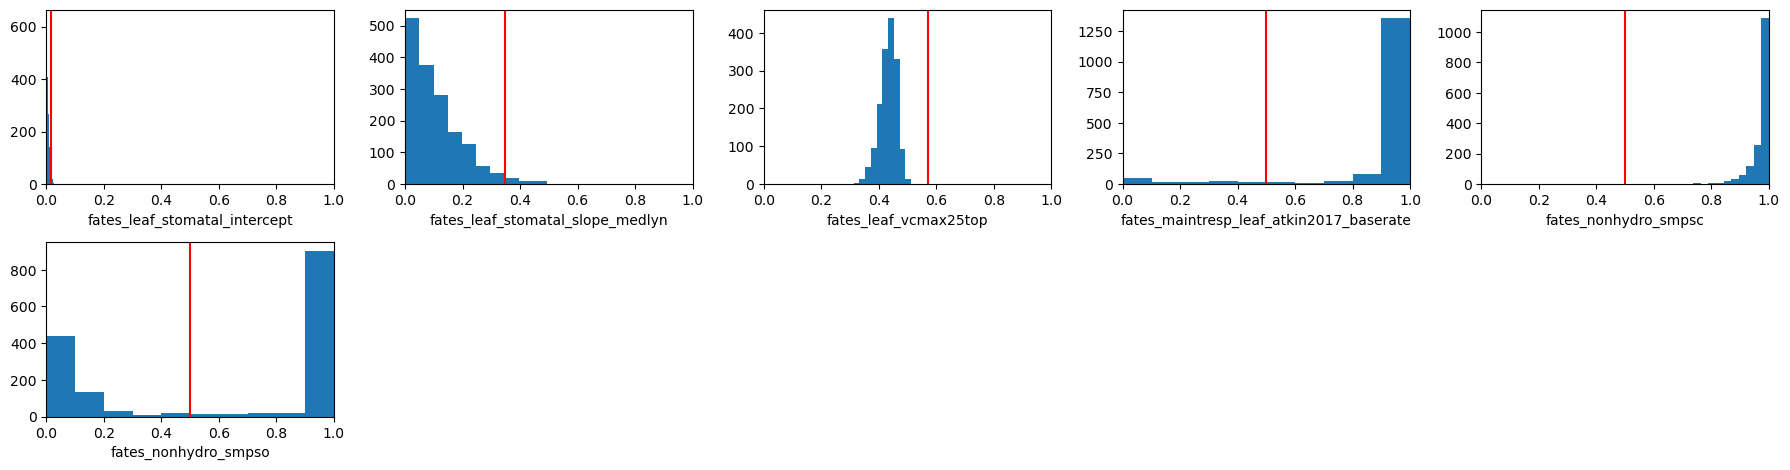

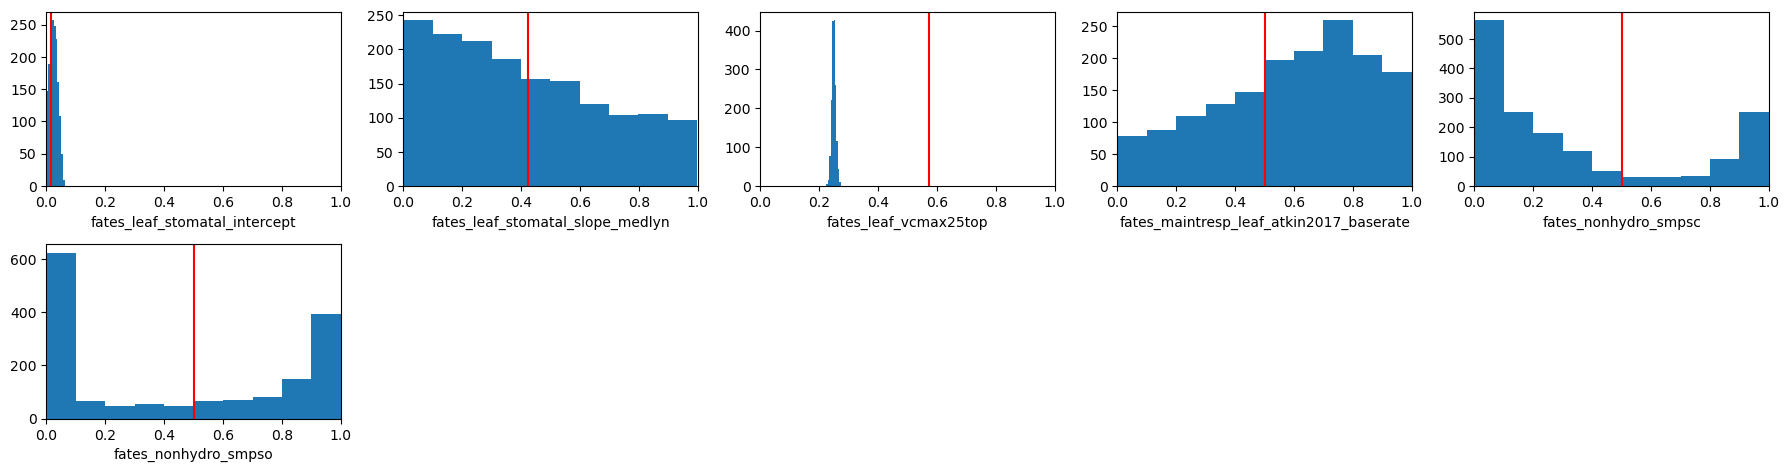

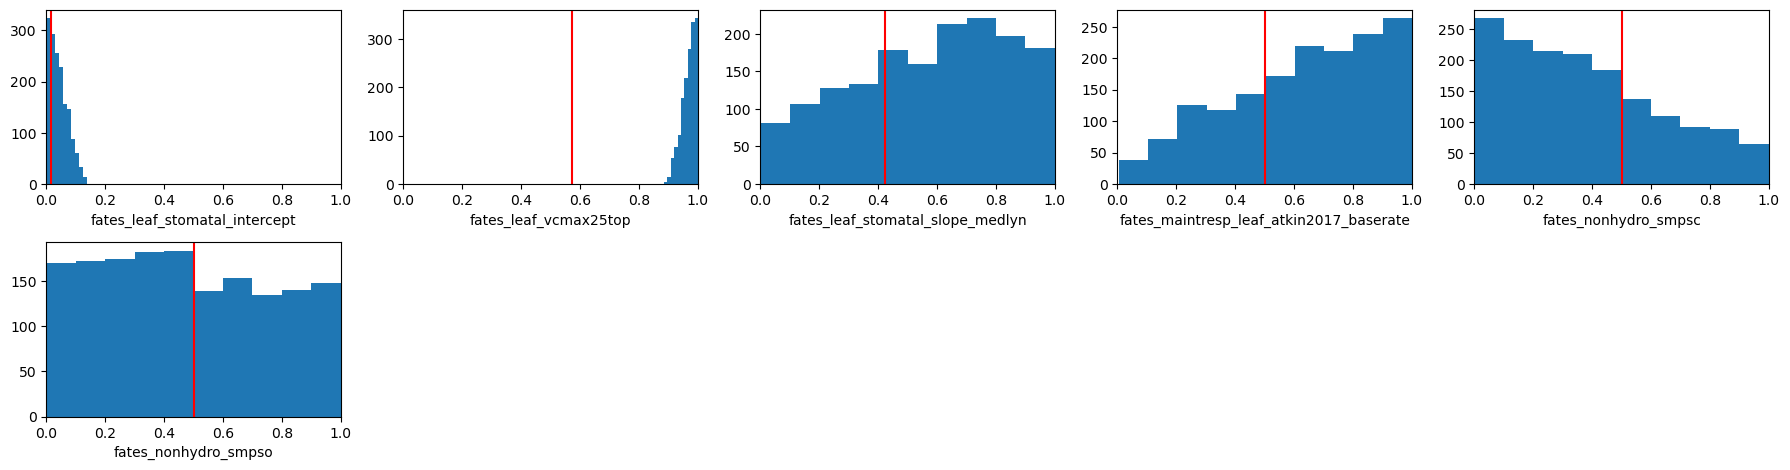

In [145]:
for pft in all_pfts:
    pft_id = FATES_PFT_IDS[pft]

    pars_pft = min_max_pars[min_max_pars.pft == str(FATES_INDEX[pft])]
    sample_dir = f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/samples"
    sample_df = get_param_samples(sample_dir)
    sample_df.to_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/sample_df.csv")
    pars = sample_df.columns
    plot_parameter_hists(sample_df, pars_pft)
    final_pars = choose_pars(sample_df, 'fates_leaf_vcmax25top', pars_pft)
    final_pars['pft'] = pft
    final_pars.to_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/final_pars.csv")

In [ ]:
# ALL PFTS

In [143]:
final_par_dfs = []
all_pfts = ['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree',
            'needleleaf_colddecid_extratrop_tree', 'arctic_c3_grass', 'cool_c3_grass',
            'c4_grass', 'broadleaf_evergreen_extratrop_tree', 'broadleaf_hydrodecid_tropical_tree',
           'broadleaf_colddecid_extratrop_tree', 'broadleaf_colddecid_extratrop_shrub', 'c3_crop',
            'c3_irrigated']
for pft in all_pfts:
    pft_id = FATES_PFT_IDS[pft]
    df = pd.read_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/final_pars.csv",
                                    index_col=[0])
    df['pft_index'] = FATES_INDEX[pft]
    final_par_dfs.append(df)
final_par_df = pd.concat(final_par_dfs)
final_par_df.to_csv('/glade/u/home/afoster/FATES_Calibration/final_parameters.csv')